In [2]:
#Imports
import math
import pandas as pd
import numpy as np
import sys
import timm
import gc
from sklearn.model_selection import GroupKFold
from sklearn import preprocessing
import torch
from torch import nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import glob
import random
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import StandardScaler, MinMaxScaler



In [3]:
#Imports
#!pip install torcheval
#import torcheval
#!pip install ffmpeg-python

import pandas as pd
import numpy as np
import sys
import gc
from sklearn.model_selection import GroupKFold
from sklearn import preprocessing

from torch.autograd import Variable 
from tqdm import tqdm
import glob
import random
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
#import torcheval
import timm
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

#from torcheval.metrics import BinaryAccuracy

from torch import nn
from sklearn.metrics import matthews_corrcoef
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

from timm.scheduler import CosineLRScheduler


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
folder = "/kaggle/input/nfl-player-contact-detection/"

In [6]:
def expand_contact_id(df):
    """
    Splits out contact_id into seperate columns.
    """
    df["game_play"] = df["contact_id"].str[:12]
    df["step"] = df["contact_id"].str.split("_").str[-3].astype("int")
    df["nfl_player_id_1"] = df["contact_id"].str.split("_").str[-2]
    df["nfl_player_id_2"] = df["contact_id"].str.split("_").str[-1]
    return df


In [7]:
test_labels = expand_contact_id(pd.read_csv(folder+"/sample_submission.csv")[["contact_id","contact"]])
test_tracking = pd.read_csv(folder+"/test_player_tracking.csv")
test_helmets = pd.read_csv(folder+"/test_baseline_helmets.csv")
test_video_metadata = pd.read_csv(folder+"/test_video_metadata.csv")

In [8]:
!mkdir -p /kaggle/test/frames

for video in tqdm(test_helmets.video.unique()):
    if 'Endzone2' not in video:
        !ffmpeg -i /kaggle/input/nfl-player-contact-detection/test/{video} -q:v 2 -f image2 /kaggle/test/frames/{video}_%04d.jpg -hide_banner -loglevel error

  0%|          | 0/4 [00:00<?, ?it/s]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 25%|██▌       | 1/4 [00:09<00:29,  9.70s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 50%|█████     | 2/4 [00:18<00:18,  9.17s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 75%|███████▌  | 3/4 [00:36<00:13, 13.15s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


100%|██████████| 4/4 [00:54<00:00, 13.66s/it]


In [9]:
#def FrameCapture(path, video):
#        vid = cv2.VideoCapture(path + video)
#        frame = 0
#        success = 1
#        if vid.isOpened():
#            print(path + video)
#            success, image = vid.read()
#            while success: 
#                
#                cv2.imwrite("/kaggle/working/frames/%s_%04d.jpg" % (video, frame), image, [int(cv2.IMWRITE_JPEG_QUALITY), 10])
#                frame += 1
#                success, image = vid.read()
#                
#            vid.release()
        

In [10]:
#!mkdir -p ../working/frames
#
#
#for video in tqdm(test_helmets.video.unique()):
#     if 'Endzone2' not in video and 'All29' not in video:
#         FrameCapture("/kaggle/input/nfl-player-contact-detection/test/", video)


In [11]:
video2helmets = {}
test_helmets_new = test_helmets.set_index('video')
for video in tqdm(test_helmets.video.unique()):
    video2helmets[video] = test_helmets_new.loc[video].reset_index(drop=True)
    
del test_helmets, test_helmets_new
gc.collect()



100%|██████████| 4/4 [00:00<00:00, 131.56it/s]


69

In [12]:
video2frames = {}

for game_play in tqdm(test_video_metadata.game_play.unique()):
    for view in ['Endzone', 'Sideline']:
        video = game_play + f'_{view}.mp4'
        video2frames[video] = max(list(map(lambda x:int(x.split('_')[-1].split('.')[0]), \
                                           glob.glob(f"/kaggle/test/frames/{video}*"))))

100%|██████████| 2/2 [00:00<00:00, 33.00it/s]


In [13]:

def create_features(df, tr_tracking, merge_col="step", use_cols=["x_position", "y_position"]):
    output_cols = []
    df_combo = (
        df.astype({"nfl_player_id_1": "str"})
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id",] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_1"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .rename(columns={c: c+"_1" for c in use_cols})
        .drop("nfl_player_id", axis=1)
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id"] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_2"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .drop("nfl_player_id", axis=1)
        .rename(columns={c: c+"_2" for c in use_cols})
        .sort_values(["game_play", merge_col, "nfl_player_id_1", "nfl_player_id_2"])
        .reset_index(drop=True)
    )
    output_cols += [c+"_1" for c in use_cols]
    output_cols += [c+"_2" for c in use_cols]
    
    if ("x_position" in use_cols) & ("y_position" in use_cols):
        index = df_combo['x_position_2'].notnull()
        
        distance_arr = np.full(len(index), np.nan)
        tmp_distance_arr = np.sqrt(
            np.square(df_combo.loc[index, "x_position_1"] - df_combo.loc[index, "x_position_2"])
            + np.square(df_combo.loc[index, "y_position_1"]- df_combo.loc[index, "y_position_2"])
        )
        
        distance_arr[index] = tmp_distance_arr
        df_combo['distance'] = distance_arr
        output_cols += ["distance"]
        
    df_combo['G_flug'] = (df_combo['nfl_player_id_2']=="G")
    output_cols += ["G_flug"]
    return df_combo, output_cols

use_cols = [
    'x_position', 'y_position', 'speed', 'distance',
    'direction', 'orientation', 'acceleration', 'sa'
]


test, feature_cols = create_features(test_labels, test_tracking, use_cols=use_cols)
test_filtered = test.query('not distance > 2.0').reset_index(drop=True)
test_filtered['frame'] = (test_filtered['step']/10*59.94+5*59.94).astype('int')+1

In [14]:
del test, test_labels, test_tracking
gc.collect()

58

In [15]:
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    #A.RandomBrightnessContrast(brightness_limit=(-0.05, 0.05), contrast_limit=(-0.05, 0.05), p=0.3),
    #A.RandomGamma(p=0.5),
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()])

valid_aug = A.Compose([
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

In [16]:
scaled_features = test_filtered.copy()

features = scaled_features[feature_cols]
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features[feature_cols] = features
test_filtered = scaled_features

del scaled_features
gc.collect()

23

In [16]:
#Want to output imgs, feature, label
#imgs.shape = 5x6x256x256
#feature.shape = 
#label.shape = 


class MyDataset_LSTM(Dataset):
    def __init__(self, df, aug=train_aug):
        self.df = df
        self.frame = df.frame.values
        self.feature = df[feature_cols].fillna(-1).values
        self.players = df[['nfl_player_id_1','nfl_player_id_2']].values
        self.game_play = df.game_play.values
        self.aug = aug
        self.contact_id = df.contact_id.values
        
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):  
        time_size = 12
        sequence = 5    #number of frames in lstm sequence
        frame = self.frame[idx]
        frame_idx = frame
        
        
        if self.aug == train_aug:
            frame = frame + random.randint(-6, 6)
        frame_diff = frame - frame_idx
        players = []
        
        #??
        for p in self.players[idx]:
            if p == 'G':
                players.append(p)
            else:
                players.append(int(p))
   
       
        imgs_arr = []
        
        for f in range(frame-((sequence//2)*time_size), frame+((sequence//2)*time_size)+1, time_size):
            imgs = []

            for view in ['Endzone', 'Sideline']:

                video = self.game_play[idx] + f'_{view}.mp4'
                
                tmp = video2helmets[video]           
                tmp = tmp[tmp.nfl_player_id.isin(players)]#.sort_values(['nfl_player_id', 'frame'])         
                tmp = tmp[tmp['frame'] == f]
                
                bboxes = []
                if len(tmp['left']):   
                    for i in range(len(tmp.index)):
                        
                        x = tmp['left'].tolist()[i]
                        w = tmp['width'].tolist()[i]
                        y = tmp['top'].tolist()[i]
                        h = tmp['height'].tolist()[i]
                        if math.isfinite(x):
                            bboxes.append([x, w, y, h])
                        
                            
                        
                        
                    img_helmet = np.zeros((720,1280), dtype=np.float32)  
                    if len(tmp) == 2:
                        
                        
                        #df_dist = self.df[(self.df['game_play'] == self.game_play) &
                        #                   (self.df['nfl_player_id_1'] == str(players[0]))  & (self.df['nfl_player_id_2'] == str(players[1]))]
                        #closest_frame = min(df_dist.frame.values, key=lambda x:abs(x-(f-frame_diff)))
                        dist = self.df.distance[idx]

                        if math.isfinite(dist):
                            color_dist = int(156+(100-(100*dist)))
                            
                        else:
                            color_dist = 100
                           
                        color = (color_dist, 0, 0)                        
                        
                    else:
                        color = (100, 0, 0)
                    
                    
                    for i in range(len(tmp)):
                        
                        start_point = (bboxes[i][0], bboxes[i][2])
                        end_point = (bboxes[i][0] +  bboxes[i][1], bboxes[i][2] + bboxes[i][3])
                        

                        img_helmet = cv2.rectangle(img_helmet, start_point, end_point, color, thickness =-1)
                    
                    
                    img_new = np.zeros((256, 256), dtype=np.float32)         
                    img = cv2.imread(f"/kaggle/test/frames/{video}_{f:04d}.jpg", 0)

                    if len(tmp) == 2:  
                        x = ((bboxes[0][0] + bboxes[1][0])/2) + ((bboxes[0][1] + bboxes[1][1])/4)
                        y = ((bboxes[0][2] + bboxes[1][2])/2) + ((bboxes[0][3] + bboxes[1][3])/4)   
                    else: 
                        x = bboxes[0][0] + (bboxes[0][1]/2)
                        y = bboxes[0][2] + (bboxes[0][3]/2)
                              
                              
                              
                              
                    img = img[int(y)-128:int(y)+128,int(x)-128:int(x)+128].copy()
                    img_helmet = img_helmet[int(y)-128:int(y)+128,int(x)-128:int(x)+128].copy()
                    img_new[:img.shape[0], :img.shape[1]] = img    
  
                    img_h = np.zeros((256, 256), dtype=np.float32)         
                    img_h[:img_helmet.shape[0], :img_helmet.shape[1]] = img_helmet               
                             
                else:
                    img_h = np.zeros((256,256), dtype=np.float32) 
                    img_new = np.zeros((256, 256), dtype=np.float32)   


                imgs.append(img_new)
                imgs.append(img_h)
                
            imgs_arr.append(imgs)
       
                
        feature = np.float32(self.feature[idx])
        row=len(imgs_arr)
        column=len(imgs_arr[0])
   
 
        imga = np.array(imgs_arr)

        b, c, h, w = imga.shape
        imga = imga.reshape(b//b, c*sequence, h, w)
        imga = np.squeeze(imga)
        imga = imga.transpose(1,2,0)
    
        imga = self.aug(image=imga)["image"]
        label = np.float32(self.df.contact.values[idx])

        
        return imga, feature, label
    


In [36]:

class MyDataset_LSTM(Dataset):
    def __init__(self, df, aug=valid_aug):
        self.df = df
        self.frame = df.frame.values
        self.feature = df[feature_cols].fillna(-1).values
        self.players = df[['nfl_player_id_1','nfl_player_id_2']].values
        self.game_play = df.game_play.values
        self.aug = aug
        self.contact_id = df.contact_id.values
        
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):  
        time_size = 12
        sequence = 5    #number of frames in lstm sequence
        frame = self.frame[idx]
        frame_idx = frame
        
        
        if self.aug == train_aug:
            print('hej')
            frame = frame + random.randint(-6, 6)
        frame_diff = frame - frame_idx
        players = []
        
        #??
        for p in self.players[idx]:
            if p == 'G':
                players.append(p)
            else:
                players.append(int(p))
   
       
        imgs_arr = []
        
        for f in range(frame-((sequence//2)*time_size), frame+((sequence//2)*time_size)+1, time_size):
            imgs = []

            for view in ['Endzone', 'Sideline']:

                video = self.game_play[idx] + f'_{view}.mp4'
                
                tmp = video2helmets[video]           
                tmp = tmp[tmp.nfl_player_id.isin(players)]#.sort_values(['nfl_player_id', 'frame'])         
                tmp = tmp[tmp['frame'] == f]
                
                bboxes = []
                img_size = 0
                if len(tmp['left']):
                  
                    for i in range(len(tmp.index)):
                        
                        x = tmp['left'].tolist()[i]
                        w = tmp['width'].tolist()[i]
                        y = tmp['top'].tolist()[i]
                        h = tmp['height'].tolist()[i]
                        if math.isfinite(x):
                            bboxes.append([x, w, y, h])
                            img_size = max([img_size, w, h])
                            
                        
                        
                    img_helmet = np.zeros((720,1280), dtype=np.float32)  
                    if len(tmp) == 2:
                        
                        
                        #df_dist = self.df[(self.df['game_play'] == self.game_play) &
                        #                   (self.df['nfl_player_id_1'] == str(players[0]))  & (self.df['nfl_player_id_2'] == str(players[1]))]
                        #closest_frame = min(df_dist.frame.values, key=lambda x:abs(x-(f-frame_diff)))
                        dist = self.df.distance[idx]

                        if math.isfinite(dist):
                            color_dist = int(156+(100-(100*dist)))
                            
                        else:
                            color_dist = 100
                           
                        color = (color_dist, 0, 0)                        
                        
                    else:
                        color = (100, 0, 0)
                    
                    
                    for i in range(len(tmp)):
                        
                        start_point = (bboxes[i][0], bboxes[i][2])
                        end_point = (bboxes[i][0] +  bboxes[i][1], bboxes[i][2] + bboxes[i][3])
                        

                        img_helmet = cv2.rectangle(img_helmet, start_point, end_point, color, thickness =-1)
                    
                    
                    img_new = np.zeros((256, 256), dtype=np.float32)         
                    img = cv2.imread(f"/kaggle/test/frames/{video}_{f:04d}.jpg", 0)
                    
                    if len(tmp) == 2:  
                        x = ((bboxes[0][0] + bboxes[1][0])/2) + ((bboxes[0][1] + bboxes[1][1])/4)
                        y = ((bboxes[0][2] + bboxes[1][2])/2) + ((bboxes[0][3] + bboxes[1][3])/4)   
                    else: 
                        x = bboxes[0][0] + (bboxes[0][1]/2)
                        y = bboxes[0][2] + (bboxes[0][3]/2)
                   
                    if x < img_size*4:
                            x = img_size * 4
                    if y < img_size * 4:
                            y = img_size * 4
                 
                    if img.size == 0:      
                        img_h = np.zeros((256,256), dtype=np.float32) 
                        img_new = np.zeros((256, 256), dtype=np.float32) 
                        
                    else:
                        
                        
                        img = img[int(y)-img_size*4:int(y)+img_size*4,int(x)-img_size*4:int(x)+img_size*4].copy()
                       
                        
                        img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_LINEAR)
                        
                        img_new[:img.shape[0], :img.shape[1]] = img 
                        
                        #img = img[int(y)-128:int(y)+128,int(x)-128:int(x)+128].copy()
                        img_helmet = img_helmet[int(y)-img_size*4:int(y)+img_size*4,int(x)-img_size*4:int(x)+img_size*4].copy()
                        img_helmet = cv2.resize(img_helmet, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)

                      
                        



                        img_h = np.zeros((256, 256), dtype=np.float32)         
                        img_h[:img_helmet.shape[0], :img_helmet.shape[1]] = img_helmet               
                             
                else:
                    
                    img_h = np.zeros((256,256), dtype=np.float32) 
                    img_new = np.zeros((256, 256), dtype=np.float32)   


                imgs.append(img_new)
                imgs.append(img_h)
                #plt.imshow(imgs[1])
                
                
                #plt.show()
                
                
            imgs_arr.append(imgs)
       
                
        feature = np.float32(self.feature[idx])
         
   
 
        imga = np.array(imgs_arr)

        b, c, h, w = imga.shape
        imga = imga.reshape(b//b, c*sequence, h, w)
        imga = np.squeeze(imga)
        imga = imga.transpose(1,2,0)
    
        imga = self.aug(image=imga)["image"]
        label = np.float32(self.df.contact.values[idx])

        
        return imga, feature, label
    

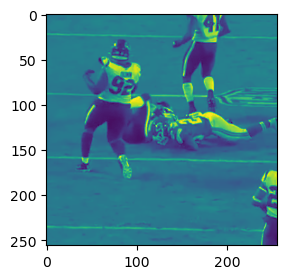

(torch.Size([20, 256, 256]),
 array([ 0.2610554 ,  0.19270723,  0.09439528,  0.07518797,  0.82561344,
         0.46468413,  0.22853185,  0.67096776, -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        ,  1.        ], dtype=float32),
 0.0)

In [37]:
img, feature, label = MyDataset_LSTM(test_filtered, valid_aug)[2000]
plt.imshow(img.permute(1,2,0)[:,:,0])
plt.rcParams["figure.figsize"] = 3,3
plt.savefig('nfl_18.png')

plt.show()
img.shape, feature, label



In [38]:
test_set = MyDataset_LSTM(test_filtered, valid_aug)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

In [39]:
class Model(nn.Module):
    def __init__(self, num_layers = 1, input_size = 256, hidden_size = 64, seq_length = 5):
        super(Model, self).__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        
        #efficientnet_b1
        self.backbone = timm.create_model('resnet50', pretrained=False, num_classes=128, in_chans=2)
        
                
        self.mlp = nn.Sequential(
            nn.Linear(18, 32),
            nn.LayerNorm(32),
            nn.ReLU(),
            nn.Dropout(0.2),
         
        )

        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) 
        self.fc_lstm = nn.Linear(hidden_size, 128) 
        
        self.softmax = nn.Softmax()
        self.fc = nn.Linear(128+32, 1)

    def forward(self, img, x):
        
        b, c, h, w = img.shape   
        img = img.reshape(b*(c//2),c//(c//2), h, w)
        img = self.backbone(img)
        img = img.reshape(b,self.seq_length, -1)


        h_0 = Variable(torch.zeros(self.num_layers, img.size(0), self.hidden_size)).to(device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, img.size(0), self.hidden_size)).to(device) #internal state
        # Propagate input through LSTM
        #self.lstm.flatten_parameters()


        output, (hn, cn) = self.lstm(img, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.softmax(hn)
        out = self.fc_lstm(out)
        #out = self.softmax(out)
    
        feature = self.mlp(x)

        #feature = torch.transpose(feature, 0, 1)
        y = self.fc(torch.cat([out, feature], dim=1))
        return y

In [40]:

model = Model()
model= nn.DataParallel(model)
model.to(device)
model.load_state_dict(torch.load('/kaggle/input/testfinalmod/nfl_model (2).pytorch'))
model.eval()

DataParallel(
  (module): Model(
    (backbone): ResNet(
      (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act2): ReLU(inplace=True)
          (aa): Identity()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bi

In [41]:
y_pred = []
with torch.no_grad():
    
        for batch,(img, feature, label) in tqdm(enumerate(test_loader),total = len(test_loader)):
            img = img.to(device)
            feature = feature.to(device)
            label = label.to(device)
            output = model(img, feature).squeeze(-1)

            y_pred.extend(output.sigmoid().cpu().numpy())

y_pred = np.array(y_pred)

100%|██████████| 415/415 [08:22<00:00,  1.21s/it]


In [42]:
th = 0.5

test_filtered['contact'] = (y_pred >= th).astype('int')

sub = pd.read_csv('/kaggle/input/nfl-player-contact-detection/sample_submission.csv')

sub = sub.drop("contact", axis=1).merge(test_filtered[['contact_id', 'contact']], how='left', on='contact_id')
sub['contact'] = sub['contact'].fillna(0).astype('int')

sub[["contact_id", "contact"]].to_csv("/kaggle/working/submission.csv", index=False)

sub.head()


,contact_id,contact
0,58168_003392_0_38590_43854,0
1,58168_003392_0_38590_41257,0
2,58168_003392_0_38590_41944,0
3,58168_003392_0_38590_42386,0
4,58168_003392_0_38590_47944,0


In [32]:
#Testa th = 0.5, 0,4, 0,45

In [33]:
x = y_pred > 0.4

In [35]:
sum(x)

0

In [36]:
y_pred

array([0.00176505, 0.00338271, 0.0017971 , ..., 0.00384274, 0.00322078,
       0.00412109], dtype=float32)